In [4]:

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
#https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [5]:
from sklearn.model_selection import train_test_split

# In this example age is the confounder 
###  Imagine that older people are at higher risk of cardiovascular disease (the outcome), but are also more likely to receive statins (the treatment). Age is affecting both the treatment decision, which here is whether or not to receive statins, and is also directly affecting the outcome, which is cardiovascular disease.

In [6]:
AGE = 'age'
MEANBP1 = 'meanbp1'
CAT1 = 'cat1'
SEX = 'sex'
DEATH = 'death' # outcome variable in the raw data
SWANG1 = 'swang1' # treatment variable in raw data
TREATMENT = 'treatment'

num_cols = [AGE, MEANBP1]
cat_cols = [CAT1, SEX, DEATH, SWANG1]

input_path = 'rhc.csv'
dtype = {col: 'category' for col in cat_cols}
df = pd.read_csv(input_path, usecols=num_cols + cat_cols, dtype=dtype)
print(df.shape)
df.head()

(5735, 6)


,cat1,death,age,sex,meanbp1,swang1
0,COPD,No,70.25098,Male,41.0,No RHC
1,MOSF w/Sepsis,Yes,78.17896,Female,63.0,RHC
2,MOSF w/Malignancy,No,46.09198,Female,57.0,RHC
3,ARF,Yes,75.33197,Female,55.0,No RHC
4,MOSF w/Sepsis,Yes,67.90997,Male,65.0,RHC


In [7]:
# SWANG1 variable shows if the particular patient is treated or no
df[SWANG1].value_counts()

No RHC    3551
RHC       2184
Name: swang1, dtype: int64

In [8]:
# some data cleaning, varibales replacement
cat1_col_mapping = {
    'ARF': 'arf',
    'MOSF w/Sepsis': 'mosf_sepsis',
    'COPD': 'copd',
    'CHF': 'chf',
    'Coma': 'coma',
    'MOSF w/Malignancy': 'mosf',
    'Cirrhosis': 'cirrhosis',
    'Lung Cancer': 'lung_cancer',
    'Colon Cancer': 'colon_cancer'
}
df[CAT1] = df[CAT1].replace(cat1_col_mapping)

col_mappings = {}
for col in (DEATH, SWANG1, SEX):
    col_mapping = dict(enumerate(df[col].cat.categories))
    col_mappings[col] = col_mapping
print(col_mappings)

for col in (DEATH, SWANG1, SEX):
    df[col] = df[col].cat.codes

df = df.rename({SWANG1: TREATMENT}, axis=1)



{'death': {0: 'No', 1: 'Yes'}, 'swang1': {0: 'No RHC', 1: 'RHC'}, 'sex': {0: 'Female', 1: 'Male'}}


In [9]:
df.head(5)

,cat1,death,age,sex,meanbp1,treatment
0,copd,0,70.25098,1,41.0,0
1,mosf_sepsis,1,78.17896,0,63.0,1
2,mosf,0,46.09198,0,57.0,1
3,arf,1,75.33197,0,55.0,0
4,mosf_sepsis,1,67.90997,1,65.0,1


In [10]:
cat_cols = [CAT1]
df_one_hot = pd.get_dummies(df[cat_cols], drop_first=True)
df_cleaned = pd.concat([df[num_cols], df_one_hot, df[[SEX, TREATMENT, DEATH]]], axis=1)
df_cleaned.head()

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex,treatment,death
0,70.25098,41.0,0,0,0,0,1,0,0,0,1,0,0
1,78.17896,63.0,0,0,0,0,0,0,0,1,0,1,1
2,46.09198,57.0,0,0,0,0,0,0,1,0,0,1,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0,0,1
4,67.90997,65.0,0,0,0,0,0,0,0,1,1,1,1


In [11]:
# cool way to get the data summary of the columns in table base don treatement
features = df_cleaned.columns.tolist()
features.remove(TREATMENT)
features.remove(DEATH)
agg_operations = {TREATMENT: 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in features})

table_one = df_cleaned.groupby(TREATMENT).agg(agg_operations)
# merge MultiIndex columns together into 1 level
# table_one.columns = ['_'.join(col) for col in table_one.columns.values]
table_one.head()


treatment        age               meanbp1             cat1_chf  \
              count       mean        std       mean        std      mean   
treatment                                                                   
0              3551  61.760926  17.287674  84.868629  38.874134  0.069558   
1              2184  60.749836  15.630698  68.197802  34.242209  0.095696   

                    cat1_cirrhosis           cat1_colon_cancer    ...     \
                std           mean       std              mean    ...      
treatment                                                         ...      
0          0.254436       0.049282  0.216486          0.001690    ...      
1          0.294241       0.022436  0.148130          0.000458    ...      

          cat1_copd           cat1_lung_cancer           cat1_mosf            \
               mean       std             mean       std      mean       std   
treatment                                                                      
0          0.112363  0.315857         0.009575  0.097395  0.067868  0.251555   
1          0.026557  0.160821         0.002289  0.047804  0.072344  0.259117   

          cat1_mosf_sepsis                 sex            
                      mean       std      mean       std  
treatment                                                 
0                 0.148409  0.355555  0.539003  0.498547  
1                 0.320513  0.466781  0.585165  0.492806  

[2 rows x 23 columns]

In [12]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4):
    feature_smds = []
    for feature in features:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd

,features,smd
0,age,0.0614
1,meanbp1,0.4551
2,cat1_chf,0.0950
3,cat1_cirrhosis,0.1447
4,cat1_colon_cancer,0.0376
5,cat1_coma,0.2073
6,cat1_copd,0.3424
7,cat1_lung_cancer,0.0950
8,cat1_mosf,0.0175
9,cat1_mosf_sepsis,0.4148


In [13]:
feature_table_one = table_one['meanbp1'].values

In [14]:
feature_table_one

array([[84.86862856, 38.87413407],
       [68.1978022 , 34.24220907]])

In [15]:
df_cleaned.columns

Index(['age', 'meanbp1', 'cat1_chf', 'cat1_cirrhosis', 'cat1_colon_cancer',
       'cat1_coma', 'cat1_copd', 'cat1_lung_cancer', 'cat1_mosf',
       'cat1_mosf_sepsis', 'sex', 'treatment', 'death'],
      dtype='object')

In [16]:
# treatment as the variable to estimate the propensity score
# death = outcome that we care about

outcome = df_cleaned[DEATH]
treatment = df_cleaned[TREATMENT]
df_cleaned = df_cleaned.drop([DEATH, TREATMENT], axis=1)


In [17]:
ct = ColumnTransformer([('numerical', StandardScaler(), num_cols)],
    sparse_threshold=0, remainder='passthrough')

data = ct.fit_transform(df_cleaned)
data.shape

(5735, 11)

In [18]:
# instantiate the model
logistic = LogisticRegression(solver='liblinear')

# fit the model with data
logistic.fit(data, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# getting an insight on ROC curve and model fitting

In [19]:
X_train,X_test,y_train,y_test=train_test_split(data, treatment,test_size=0.25,random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

#Model Evaluation using Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

C:\Users\Sidhant\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[779, 126],
       [335, 194]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

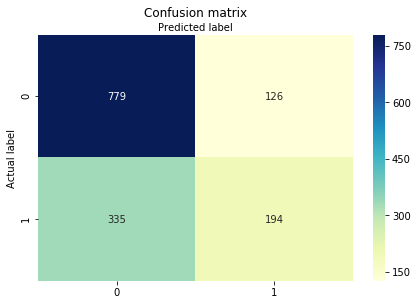

In [20]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [21]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.6785216178521618
Precision: 0.60625
Recall: 0.3667296786389414


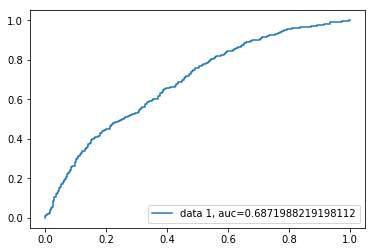

In [22]:

#ROC curve
#Receiver Operating Characteristic(ROC) curve is a plot of the true positive 
#rate against the false positive rate. 
#It shows the tradeoff between sensitivity and specificity.

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
#AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

# end of ROC. start of propensity score

In [23]:
# propensity score
pscore = logistic.predict_proba(data)[:, 1]
pscore

array([0.20155262, 0.55090836, 0.40984889, ..., 0.17665095, 0.18751032,
       0.22041232])

In [24]:
StandardScaler?

In [25]:
ct

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0,
         transformer_weights=None,
         transformers=[('numerical', StandardScaler(copy=True, with_mean=True, with_std=True), ['age', 'meanbp1'])])

In [26]:
df_cleaned.head(5)

,age,meanbp1,cat1_chf,cat1_cirrhosis,cat1_colon_cancer,cat1_coma,cat1_copd,cat1_lung_cancer,cat1_mosf,cat1_mosf_sepsis,sex
0,70.25098,41.0,0,0,0,0,1,0,0,0,1
1,78.17896,63.0,0,0,0,0,0,0,0,1,0
2,46.09198,57.0,0,0,0,0,0,0,1,0,0
3,75.33197,55.0,0,0,0,0,0,0,0,0,0
4,67.90997,65.0,0,0,0,0,0,0,0,1,1


In [27]:
data[0]

array([ 0.53206501, -0.98624691,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ])

In [28]:
'''from sklearn.preprocessing import Normalizer

ct = ColumnTransformer(
     [("norm1", Normalizer(norm='l1'), [0, 1]),
      ("norm2", Normalizer(norm='l1'), slice(2, 4))])

X = np.array([[0., 1., 2., 2.],
               [1., 1., 0., 1.]])
# Normalizer scales each row of X to unit norm. A separate scaling
# is applied for the two first and two last elements of each
# row independently.
ct.fit_transform(X)'''

'from sklearn.preprocessing import Normalizer\n\nct = ColumnTransformer(\n     [("norm1", Normalizer(norm=\'l1\'), [0, 1]),\n      ("norm2", Normalizer(norm=\'l1\'), slice(2, 4))])\n\nX = np.array([[0., 1., 2., 2.],\n               [1., 1., 0., 1.]])\n# Normalizer scales each row of X to unit norm. A separate scaling\n# is applied for the two first and two last elements of each\n# row independently.\nct.fit_transform(X)'

In [29]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (2184,)
control count: (3551,)


C:\Users\Sidhant\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


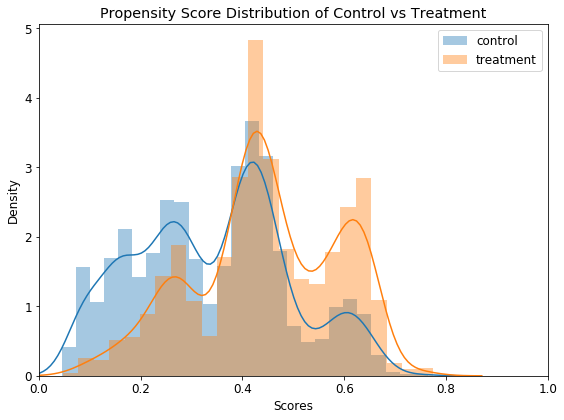

In [30]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()